# Projectile Motion

This section will look at solving the projectile motion of a baseball. Without air resistance, the problem can be solved with elementary physics. With air resistance, however, we must resort to numerical methods. 

The equation of motion for the baseball is:

$$ \frac{dv}{dt} = \frac{1}{m}F_a(v) - g\hat y $$

The force of air resistance is a function of the velocity. The last term is the gravitational acceleration multiplied by the unit vector in the y-direction. The force from air resistance is often approximated as:

$$ F_a = -\frac{1}{2}C_d\rho A |v|v $$

The drag coefficient of a baseball is dependent on its Reynolds number. Its drag coefficient is also typically lower than that of a smooth sphere because the stitching disrupts laminar flow around the ball, precipitating the onset of turbulence. At low Reynolds numbers, the drag coefficient is dependent on the Re itself. At higher Re, vortex shedding maintains a nearly constant drag coefficient of about 0.5. At the critical Re (approximately $3x10^{5}$ for a smooth sphere), turbulent flow disrupts the low pressure region in the wake behind the sphere.

A baseball's mass and diameter are 0.145 kg and 7.4 cm.

## Forward Derivative

Performing the numerical analysis requires computation of the derivative. The derivative is defined as:

$$ f'(x) = \lim_{\tau \to 0} \frac{f(t + \tau) - f(t)}{\tau} $$

A special version of a Taylor expansion can be used where:

$$ f(t + \tau) = f(t) + \tau f'(t) + \frac{\tau^2}{2}f''(\zeta) $$

Where $\zeta$ is a value between $t$ and $t + \tau$. The above expression can be rewritten as:

$$ f'(t) = \frac{f(t + \tau) - f(t)}{\tau} - \frac{1}{2}\tau f''(\zeta) $$

The last term is the truncation error. If the term is kept, the expression for $f'(t)$ is exact. But, we can't compute that term, because we don't know what $\zeta$ is. But, we can bound the error, because we know the limits: $\zeta$ is somewhere between $t$ and $t + \tau$.

## Euler's Method

The equations of motion to be solved, generally, are:

$$\frac{dv}{dt} = a(r, v); \frac{dr}{dt} = v $$

In projectile motion, the acceleration is only a function of $v$ because of air resistance. In later sections, such as the motions of comets, acceleration will also be a function of position.

Using the forward derivative, the equations of motion are:

$$ \frac{v(t + \tau) - v(t)}{\tau} + O(\tau) = a(r(t), v(t)) $$

$$ \frac{r(t + \tau) - r(t)}{\tau} + O(\tau) = v(t) $$

Which, when rearranged, evaluate to:

$$ v(t + \tau) = v(t) + \tau a(r(t), v(t)) + O(\tau^2) $$

$$ r(t + \tau) = r(t) + \tau v(t) + O(\tau^2) $$

How is Euler's method implemented in practice? First, a change in notation. $f_n = f(t_n); t_n = n\tau; n = 0, 1, ...$, so $f_0 = f(t=0)$. Dropping the error term from above, our updates become:

$$v_{n+1} = v_n + \tau a_n$$

$$r_{n+1} = r_n + \tau v_n$$

The calculation of the trajectory proceeds as follows:

1. Specify the initial conditions, $r_0$ and $v_0$. 
2. Choose a time step $\tau$.
3. Calculate the acceleration given the current r and v.
4. Use the previous two equations to update r and v.
5. Proceed back to step 3 and continue until the desired number of trajectory points have been calculated.

An alternative to the Euler method is the _Euler-Cromer_ method, which uses the updated velocity to update the position. This changes the second equation to be:

$$r_{n+1} = r_n + \tau v_{n+1}$$

Additionally, the _midpoint method_ also changes the position equation. For the midpoint method, the second equation becomes:

$$r_{n+1} = r_n + \tau \frac{v_{n+1} + v_n}{2}$$

which is obviously an average of the second term of the Euler and Euler-Cromer methods. Inserting the equation for velocity into the midpoint method returns the familiar projectile equation:

$$ r_{n+1} = r_n + \tau v_n + \frac{1}{2}a_n \tau^2 $$

By making some comparisons to equations in the book, we can see that the error is on the order of $\tau^2 a$. If the acceleration were $10 m/s^2$, then the single-step truncation error would be $10^{-1} m$ for $\tau = 10^{-1} s$.

For implementing trajectory analysis using the Euler method:

1. Set initial position $r_0$ and initial velocity $v_0$.
2. Set the physical parameters ($m, C_d$, etc.)
3. Loop until the ball hits the ground or maximum steps are completed
    - Record position for plotting
    - Compute acceleration
    - Calaulate the new position and velocity
    - If the ball reaches the ground (y < 0), break the loop
4. Print max range and time of flight
5. Graph the trajectory

In [3]:
import numpy as np

In [116]:
def balle():
    ''' Function to compute the trajectory of a baseball using the Euler method'''
    ''' The drag coefficient is calculated using quadratic interpolation based on information
    given for Cd vs speeds between 0 and 55.9 m/s (125 mph). Therefore, speeds above 125 mph
    will lead to inaccurate results.
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    
    ## Set initial position and velocity of the baseball
    y0 = float(input('Enter initial height (meters): '))
    r0 = np.array([0, y0]) # initial position vector
    speed = float(input('Enter initial speed (m/s): '))
    theta = float(input('Enter initial angle (degrees): '))
    v0 = np.array([speed * np.cos(theta*np.pi/180), 
                  speed * np.sin(theta*np.pi/180)]) # vector components of speed
    r = np.copy(r0)
    v = np.copy(v0)
    
    ## Set physical parameters
    #Cd = 0.35          # drag coefficient
    area = 4.3e-3      # cross-sectional area (m^2)
    grav = 9.81        # gravitational acceleration (m/s^2)
    mass = .145       # mass of projectile (kg)
    airFlag = int(input('Air resistance? (Yes: 1, No: 0)'))
    if airFlag:
        rho = 1.2      # density of air (kg/m^3)
    else:
        rho = 0
    
    ## Loop until ball hits the ground or max steps completed
    tau = float(input('Enter time step (sec): '))    # time step (sec)
    maxstep = 1000      # max number of time steps
    xplot = np.empty(maxstep)
    yplot = np.empty(maxstep)
    xNoAir = np.empty(maxstep)
    yNoAir = np.empty(maxstep)
    
    for istep in range(maxstep):
        # Interpolate Cd based on speed
        speed = np.linalg.norm(v)
        if speed <= 22.4:
            Cd = 0.5
        elif speed > 22.4 and speed <= 44.7:
            v_interp = np.array([22.4, 33.5, 44.7])
            Cd_interp = np.array([0.5, 0.4, 0.28])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
        else:
            v_interp = np.array([33.5, 44.7, 55.9])
            Cd_interp = np.array([0.4, 0.28, 0.23])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
            
        
        air_const = -0.5 * Cd * rho * area / mass  # air resistance constant based on Cd
            
        xplot[istep] = r[0]    # record trajectory for each plot
        yplot[istep] = r[1]
        t = istep * tau        # current time
        xNoAir[istep] = r0[0] + v0[0] * t
        yNoAir[istep] = r0[1] + v0[1] * t - 0.5 * grav * t**2
        
        # calculate acceleration
        accel = air_const * np.linalg.norm(v) * v   # air resistance
        accel[1] -= grav                            # gravity
        
        # Calculate new position and velocity using Euler method
        r = r + tau * v          # Euler step
        v = v + tau * accel
        
        # If ball reaches ground (y < 0), break out of loop
        if r[1] < 0:
            laststep = istep + 1
            xplot[laststep] = r[0]   # record last values
            yplot[laststep] = r[1]
            break
    
    # Interpolate to find true (corrected) range based on where the last point closest to the 
    # ground, i.e. the last positive y value
    x, y, interp_range = interp(xplot[laststep-3:laststep+1], yplot[laststep-3:laststep+1])
    
    # Print max range and time of flight
    print(f'Corrected range is {interp_range[0]:.2f} meters')
    print(f'Simple range is {r[0]:.2f} meters')
    print(f'Time of flight is {laststep*tau:.1f} seconds')
    
    ## Graph the trajectory
    # Mark the location of the ground by a straight line
    xground = np.array([0., xNoAir[laststep-1]])
    yground = np.array([0., 0.])
    
    # plot the computed trajectory with no air
    plt.plot(xplot[0:laststep+1], yplot[0:laststep+1], '+', label='Euler Method')
    plt.plot(xNoAir[0:laststep], yNoAir[0:laststep], '-', label='Theory (no air)')
    plt.plot(xground, yground, 'r-')
    #plt.plot(x, y, 'b--', label='Interpolation')
    plt.legend()
    plt.xlabel('Range (m)')
    plt.ylabel('Height (m)')
    plt.title('Projectile motion')
    plt.show()

Enter initial height (meters):  1
Enter initial speed (m/s):  50
Enter initial angle (degrees):  45
Air resistance? (Yes: 1, No: 0) 1
Enter time step (sec):  0.1


Corrected range is 120.50 meters
Simple range is 121.06 meters
Time of flight is 6.0 seconds


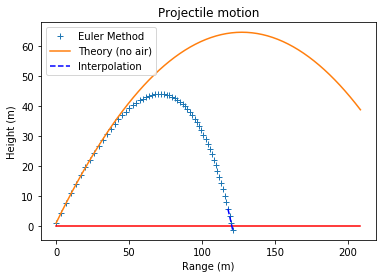

In [117]:
balle()

We now want to make a correction to the program. The _balle_ function will overestimate the range, since it chooses the final iteration as the range, which is at y < 0. Instead, we will modify the linear interpolation function from the previous chapter, and have it return the x value where y = 0.

In [91]:
def interp(x, y):
    ''' Function to perform quadratic interpolation on a set of 3 data points'''
    import matplotlib.pyplot as plt
    xmin = x[0]
    xmax = x[-1]
    
    xi = np.linspace(xmin, xmax, 100)
    
    yi = ((xi - x[1])*(xi - x[2]))/((x[0] - x[1])*(x[0] - x[2])) * y[0] + \
         ((xi - x[0])*(xi - x[2]))/((x[1] - x[0])*(x[1] - x[2])) * y[1] + \
         ((xi - x[0])*(xi - x[1]))/((x[2] - x[0])*(x[2] - x[1])) * y[2]
    
#     plt.plot(x, y, '*', label='Given points')
#     plt.plot(xi, yi, '--', label='interpolation')
#     plt.legend()

    y_ = yi[yi > 0]
    ymin = min(y_)
    
    return x, y, xi[yi==ymin]

In [111]:
def interp_Cd(x, y, target):
    ''' Function to perform quadratic interpolation on a set of 3 data points'''
    
    xmin = x[0]
    xmax = x[-1]
    
    xi = np.linspace(xmin, xmax, 100)
    
    yi = ((xi - x[1])*(xi - x[2]))/((x[0] - x[1])*(x[0] - x[2])) * y[0] + \
         ((xi - x[0])*(xi - x[2]))/((x[1] - x[0])*(x[1] - x[2])) * y[1] + \
         ((xi - x[0])*(xi - x[1]))/((x[2] - x[0])*(x[2] - x[1])) * y[2]
    
    return yi[abs(xi - target).argmin()]

In [63]:
x = np.array([1, 2, 3])
y = np.array([9, 7, 3])

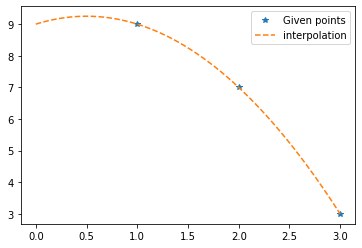

In [65]:
ans = interp(x, y)

The balle function above was ultimately update to include a dynamic drag coefficient, and to interpolate the last three position updates to find the range that represents the closest point that the ball gets to the ground without actually having a negative y value. Using the final point overestimates the range, which you see in the corrected vs simple ranges that are printed out.

Below is an implementation of the Euler-Cromer update step instead of the Euler step. The only difference is reversing the order that the position and velocity get updated in. In Euler-Cromer, the velocity is updated first, and then the position is updated using the updated velocity. For the same initial conditions (1m height, 50 m/s speed, 45 degree angle, 0.1 sec time interval), the Euler-Cromer results were about 5 meters shorter than the Euler results. 

In [123]:
def balle_EulerCromer():
    import numpy as np
    import matplotlib.pyplot as plt
    
    ## Set initial position and velocity of the baseball
    y0 = float(input('Enter initial height (meters): '))
    r0 = np.array([0, y0]) # initial position vector
    speed = float(input('Enter initial speed (m/s): '))
    theta = float(input('Enter initial angle (degrees): '))
    v0 = np.array([speed * np.cos(theta*np.pi/180), 
                  speed * np.sin(theta*np.pi/180)]) # vector components of speed
    r = np.copy(r0)
    v = np.copy(v0)
    
    ## Set physical parameters
    #Cd = 0.35          # drag coefficient
    area = 4.3e-3      # cross-sectional area (m^2)
    grav = 9.81        # gravitational acceleration (m/s^2)
    mass = .145       # mass of projectile (kg)
    airFlag = int(input('Air resistance? (Yes: 1, No: 0)'))
    if airFlag:
        rho = 1.2      # density of air (kg/m^3)
    else:
        rho = 0
    
    ## Loop until ball hits the ground or max steps completed
    tau = float(input('Enter time step (sec): '))    # time step (sec)
    maxstep = 1000      # max number of time steps
    xplot = np.empty(maxstep)
    yplot = np.empty(maxstep)
    xNoAir = np.empty(maxstep)
    yNoAir = np.empty(maxstep)
    
    for istep in range(maxstep):
        # Interpolate Cd based on speed
        speed = np.linalg.norm(v)
        if speed <= 22.4:
            Cd = 0.5
        elif speed > 22.4 and speed <= 44.7:
            v_interp = np.array([22.4, 33.5, 44.7])
            Cd_interp = np.array([0.5, 0.4, 0.28])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
        else:
            v_interp = np.array([33.5, 44.7, 55.9])
            Cd_interp = np.array([0.4, 0.28, 0.23])
            Cd = interp_Cd(v_interp, Cd_interp, speed)
            
        
        air_const = -0.5 * Cd * rho * area / mass  # air resistance constant based on Cd
            
        xplot[istep] = r[0]    # record trajectory for each plot
        yplot[istep] = r[1]
        t = istep * tau        # current time
        xNoAir[istep] = r0[0] + v0[0] * t
        yNoAir[istep] = r0[1] + v0[1] * t - 0.5 * grav * t**2
        
        # calculate acceleration
        accel = air_const * np.linalg.norm(v) * v   # air resistance
        accel[1] -= grav                            # gravity
        
        # Calculate new position and velocity using Euler method
        v = v + tau * accel
        r = r + tau * v      # Euler-Cromer step
        # If ball reaches ground (y < 0), break out of loop
        if r[1] < 0:
            laststep = istep + 1
            xplot[laststep] = r[0]   # record last values
            yplot[laststep] = r[1]
            break
        
        # Interpolate to find true (corrected) range based on where the last point closest to the 
    # ground, i.e. the last positive y value
    x, y, interp_range = interp(xplot[laststep-3:laststep+1], yplot[laststep-3:laststep+1])
    
    # Print max range and time of flight
    print(f'Corrected range is {interp_range[0]:.2f} meters')
    print(f'Simple range is {r[0]:.2f} meters')
    print(f'Time of flight is {laststep*tau:.1f} seconds')
    
    ## Graph the trajectory
    # Mark the location of the ground by a straight line
    xground = np.array([0., xNoAir[laststep-1]])
    yground = np.array([0., 0.])
    
    # plot the computed trajectory with no air
    plt.plot(xplot[0:laststep+1], yplot[0:laststep+1], '+', label='Euler-Cromer Method')
    plt.plot(xNoAir[0:laststep], yNoAir[0:laststep], '-', label='Theory (no air)')
    plt.plot(xground, yground, 'r-')
    #plt.plot(x, y, 'b--', label='Interpolation')
    plt.legend()
    plt.xlabel('Range (m)')
    plt.ylabel('Height (m)')
    plt.title('Projectile motion')
    plt.show()

Enter initial height (meters):  1
Enter initial speed (m/s):  50
Enter initial angle (degrees):  45
Air resistance? (Yes: 1, No: 0) 1
Enter time step (sec):  0.1


Corrected range is 115.33 meters
Simple range is 115.37 meters
Time of flight is 5.7 seconds


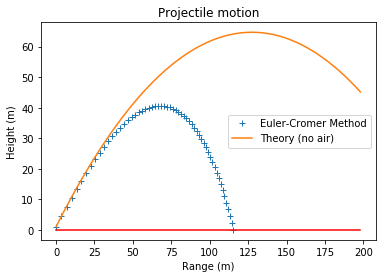

In [124]:
balle_EulerCromer()

# Simple Pendulum

The equation of motion for a pendulum can be derived from the equation for torque, which is equal to the moment of inertia multiplied by the angular acceleration:

$$ \tau = I\alpha $$

The torque is given by the length of the pendulum $L$ multiplied by the component of force perpenducular to the pendulum arm. For gravitational forces only, that component is $mgsin\theta$. Therefore, the equation of motion for a simple pendulum is:

$$ \frac{d^2\theta}{dt^2} = -\frac{g}{L}sin\theta $$